/usr/lib64/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


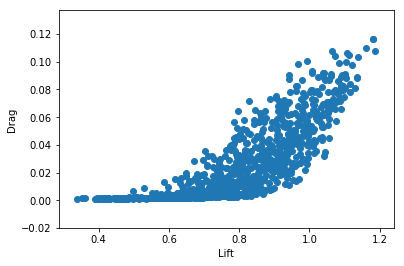

In [1]:
import sys
sys.path.append('../python')
import time
from plot_info import *
from keras.models import Sequential
from keras.layers import Dense, Activation
import keras
import scipy.stats
import h5py
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from print_table import *


import numpy as np
random_seed = 42

import numpy.random
import tensorflow

def seed_random_number(seed):
    numpy.random.seed(seed)
    tensorflow.set_random_seed(seed)
    
seed_random_number(random_seed)

qmc_points = np.loadtxt('../sobol_6_8000.txt')
qmc_points = qmc_points[1:].reshape((8000,6))

all_points = qmc_points.copy()
forces = np.array(np.loadtxt('../force_6_params.dat'))

plt.scatter(forces[:,1], forces[:,2])
plt.xlabel("Lift")
plt.ylabel("Drag")
plt.show()

N = min(qmc_points.shape[0], forces.shape[0])
qmc_points = qmc_points[:N,:]
forces  = forces[:N,:]

permuted_indices = range(N)
qmc_points=qmc_points[permuted_indices,:]
forces = forces[permuted_indices,:]
input_size=6
force_component = 1
train_size=128
validation_size=200



In [2]:
def get_network(parameters, data, *,train_size, validation_size, batch_size, title, optimizer,
               speedup_table, comparison_table, 
               wasserstein_table_builder,
               bilevel_speedup_table,
               prediction_error_table):
    
    best_network = None
    best_network_index = None
    best_learning_rate = None
    best_weights = None
    
    
    tries = 5
    start_total_learning = time.time()
    for trylearn in range(tries):
        model = Sequential([
            Dense(10, input_shape=(input_size,)),
            Activation('relu'),
            Dense(12),
            Activation('relu'),
            Dense(10),
            Activation('relu'),
            Dense(12),
            Activation('relu'),
            Dense(10),
            Activation('relu'),
            Dense(10),
            Activation('relu'),
            Dense(1)
        ])
        
       
        
       
            
        
        model.compile(optimizer=optimizer(lr=0.01),
                      loss='mean_squared_error')
        
        weights = np.copy(model.get_weights())
        x_train = parameters[:train_size,:]
        y_train=data[:train_size]
        
        
        x_val = parameters[train_size:validation_size+train_size,:]
        y_val=data[train_size:train_size+validation_size]
        epochs=500000
        
        training_start_time=time.time()
        hist = model.fit(x_train, y_train,batch_size=batch_size, epochs=epochs,shuffle=True, 
                         validation_data=(x_val, y_val),verbose=0)
        training_end_time=time.time()
        print("Training took {} seconds".format (training_end_time-training_start_time))
        console_log("Training took {} seconds".format (training_end_time-training_start_time))
        if best_network is None or hist.history['loss'] < best_learning_rate:
            best_network = model
            best_network_index = trylearn
            best_learning_rate = hist.history['loss']
            best_weights = weights
            
    
            
    end_total_learning = time.time()
    
    print("Best network index: %d" % best_network_index)
    console_log("Best network index: %d" % best_network_index)
    print("Total learning time took: %d s" % (end_total_learning-start_total_learning))
    console_log("Total learning time took: %d s" % (end_total_learning-start_total_learning))
    model = best_network
    print_keras_model_as_table('airfoilnetwork', model)
    weights = best_weights
    
    # save model to file, see https://machinelearningmastery.com/save-load-keras-deep-learning-models/
    model_json = model.to_json()
    with open("results/" + showAndSave.prefix + "model.json", "w") as json_file:
        json_file.write(model_json)
    model.save_weights("results/" + showAndSave.prefix + "model.h5")
    np.save("results/" + showAndSave.prefix + "intial.npy", weights)
    
    epochs_r=range(1, epochs)
    plt.loglog(hist.history['loss'])
    plt.title('Training loss (%d samples, batch size: %d)\n%s' %(train_size, batch_size, title))
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    showAndSave('training_loss')
    
    plt.loglog(hist.history['val_loss'])
    plt.title('Validation loss (%d samples, batch size: %d)\n%s' %(train_size, batch_size, title))
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    showAndSave('validation_loss')
    
    
    
    plt.loglog(hist.history['loss'], label='Training loss')
    plt.loglog(hist.history['val_loss'],label='Validation loss')
    plt.legend()
    plt.title('Training loss and validation loss (%d samples, batch size: %d)\n%s' %(train_size, batch_size, title))
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    showAndSave('training_validation_loss')
    
   
    
    
    x_test =  parameters[validation_size+train_size:,:]
    y_test = data[train_size+validation_size:]
    y_predict = model.predict(x_test)
    
    plt.title('Scatter comparision (%d samples, batch size: %d)\n%s' %(train_size, batch_size, title))
    plt.scatter(y_test, y_predict)
    plt.xlabel("Actual data")
    plt.ylabel("Predicted data")
    showAndSave("scatter_comparison")
    print(model.summary())
    
   
    from sklearn import linear_model
    reg = linear_model.LinearRegression()
    coeffs = reg.fit(parameters[:train_size,:], y_train)
    
    evaluated_lsq = coeffs.predict(parameters)
    plt.scatter(data, evaluated_lsq)
    plt.title('Linear Least squares (%d samples)' % (train_size))
    plt.xlabel("Actual data")
    plt.ylabel("Interpolated data")
    showAndSave("scatter_lsq_comparision")
    
    
    def myvar(x):
        mean = np.sum(x)/x.shape[0]
        var = np.sum((mean-x)**2)/x.shape[0]
        return var
        
    def mymean (x): 
        return np.sum(x)/x.shape[0]
    
    variance_top = myvar(data)
    print("variance single level = %f" % variance_top)
    predicted = model.predict(parameters)
    predicted = predicted.reshape(parameters.shape[0])
    variance_diff_ml = myvar(data - predicted)
    
    
    print("variance diff ml = %f " % variance_diff_ml)
    print("speedup = %f" % (variance_top/variance_diff_ml))
    bilevel_speedup_table.set_header(["Functional", "DLbQMC Speedup"])
    bilevel_speedup_table.add_row([title, variance_top/variance_diff_ml])
    print((data - evaluated_lsq).shape)
    variance_diff_interpolate =myvar(data - evaluated_lsq)
    print("variance_diff_interpolate = %f" % variance_diff_interpolate)
    
    
    
    mean_qmc = np.mean(data)
    print("mean_qmc = %f" % mean_qmc)
    mean_ml = np.mean(model.predict(parameters))
    print("mean_ml = %f" % mean_ml)
    mean_few_qmc = np.mean(parameters[:train_size,:])
    
    print("mean_few_qmc = %f" % mean_few_qmc)
    predicted_all = model.predict(all_points)
    predicted_all = predicted_all.reshape(all_points.shape[0])
    print(predicted_all.shape)
    mean_mlmlmc = mymean(predicted[:train_size]-data[:train_size]) + mymean(predicted_all)
    
    print("mean_mlmlmc = %f" % mean_mlmlmc)
    var_qmc = np.var(data)
    print("var_qmc = %f" % var_qmc)
    var_ml = np.var(model.predict(parameters))
    print("var_ml = %f" % var_ml)
    var_few_qmc = np.var(parameters[:train_size,:])
    
    print("var_few_qmc = %f" % var_few_qmc)
    print(parameters.shape)
    
    
   
    plt.hist(data,bins=40,density=True,label='QMC %d samples' % parameters.shape[0],alpha=0.5)
    plt.title("Comparison QMC and DLQMC\n%s\nepochs=%d,batch_size=%d"% (title, epochs,batch_size))
    plt.hist(model.predict(parameters),bins=40,density=True,label='DLQMC (%d samples)' % train_size,alpha=0.5)
    plt.legend()
    showAndSave('hist_qmc_ml_%s' % title)
    
    
    plt.title("Comparison QMC with %d and QMC with %d samples\n%s" %(parameters.shape[0], train_size, title))
    plt.hist(data,bins=40,density=True,label='QMC %d samples' % parameters.shape[0],alpha=0.5)
    plt.hist(data[:train_size],bins=40,density=True, alpha=0.5,label='QMC %d samples' % train_size)
    plt.legend()
    showAndSave('hist_qmc_qmc_%s' % title)
    
    plt.title("Comparison QMC with least squares\n%s" % title)
    plt.hist(data,bins=40,density=True,label='QMC %d samples' % train_size,alpha=0.5)
    plt.hist(evaluated_lsq,bins=40,density=True,alpha=0.5, label='Least squares (%d points)' % train_size)
    plt.legend()
    showAndSave('hist_qmc_lsq_%s' % title)
    
    
    
    
    plt.hist(data,bins=20,density=True,label='QMC %d samples' % parameters.shape[0],alpha=0.5)
    plt.title("(coarse hist) Comparison QMC and DLQMC\n%s\nepochs=%d,batch_size=%d"% (title, epochs,batch_size))
    plt.hist(model.predict(parameters),bins=20,density=True,label='DLQMC(%d samples)' % train_size,alpha=0.5)
    plt.legend()
    showAndSave('hist_qmc_ml_coarse_%s' % title)
    
    
    plt.title("(coarse hist) Comparison QMC with %d and QMC with %d samples\n%s" %(parameters.shape[0], train_size, title))
    plt.hist(data,bins=20,density=True,label='QMC %d samples' % parameters.shape[0],alpha=0.5)
    plt.hist(data[:train_size],bins=20,density=True, alpha=0.5,label='QMC %d samples' % train_size)
    plt.legend()
    showAndSave('hist_qmc_qmc_coarse_%s' % title)
    
    plt.title("(coarse hist) Comparison QMC with least squares\n%s" % title)
    plt.hist(data,bins=20,density=True,label='QMC %d samples' % train_size,alpha=0.5)
    plt.hist(evaluated_lsq,bins=20,density=True,alpha=0.5, label='Least squares (%d points)' % train_size)
    plt.legend()
    showAndSave('hist_qmc_lsq_coarse_%s' % title)
    
    
    
    
    prediction_error = np.sum(keras.backend.eval(keras.losses.mean_squared_error(data, model.predict(parameters))))/data.shape[0]
    prediction_error_lsq = np.sum(keras.backend.eval(keras.losses.mean_squared_error(data, evaluated_lsq)))/data.shape[0]
    
    print(prediction_error)
    
    
    prediction_error_table.set_header(["Functional", "Deep learning", "Least squares"])
    prediction_error_table.add_row([title, prediction_error, prediction_error_lsq])
    
    
    
    
    samples = range(0,data.shape[0])
    stats = {}
    for stat in ['mean', 'var']:
        stats[stat]={}
        stats[stat]['sources']={}
        if stat == 'mean':
            stats[stat]['compute']=lambda x: sum(x)/x.shape[0]
        else:
            stats[stat]['compute']=lambda x: sum(x**2)/x.shape[0]-(sum(x)/x.shape[0])**2
    
     
        stats[stat]['sources']['QMC']={}
        stats[stat]['sources']['DLQMC'] = {}
        stats[stat]['sources']['Least squares'] = {}
        stats[stat]['sources']['DLbQMC'] = {}
    
        stats[stat]['sources']['QMC']['data']=array([stats[stat]['compute'](data[:k]) for k in samples])
        stats[stat]['sources']['DLQMC']['data'] = array([stats[stat]['compute'](array(model.predict(parameters[:k,:]))) for k in samples])
        stats[stat]['sources']['Least squares']['data'] = array([stats[stat]['compute'](evaluated_lsq[:k]) for k in samples])
        
        stats[stat]['sources']['DLbQMC']['data'] = [0]
        
        for k in samples[1:]:
            if stat == 'mean':
                mean = sum(model.predict(parameters[:train_size,:])-data[:train_size])/train_size +\
                sum(model.predict(parameters[:k,:]))/k
                

                stats[stat]['sources']['DLbQMC']['data'].append(mean)
            elif stat=='var':
                mean = sum(model.predict(parameters[:train_size,:])-data[:train_size])/train_size +\
                sum(model.predict(parameters[:k,:]))/k
                
                m2 = sum((data[:train_size])**2-(model.predict(parameters[:train_size,:]))**2)/train_size +\
                sum(model.predict(parameters[:k,:])**2)/k
                

                stats[stat]['sources']['DLbQMC']['data'].append(m2-mean**2)
                
        stats[stat]['sources']['DLbQMC']['data']=array(stats[stat]['sources']['DLbQMC']['data'])
        
        sources = stats[stat]['sources'].keys()
        for source in sources:
            
            stats[stat]['sources'][source]['representative'] = stats[stat]['sources'][source]['data'][-1]
            
        
       
    
        for source in stats[stat]['sources'].keys():
            if 'DLbQMC' not in source:
                plt.plot(samples, stats[stat]['sources'][source]['data'], label=source)
        plt.xlabel('Number of samples ($J_L$)')
        plt.ylabel('%s' % stat)
        plt.title('%s as a function of number of samples used for evaluation\n%s' % (stat, title))
        plt.legend()
        showAndSave('function_of_samples_airfoil_%s_%s'  % (stat, title))
        stats[stat]['sources']['QMC_%d' % train_size] = {}
        stats[stat]['sources']['QMC_%d' % train_size]['representative'] = stats[stat]['sources']['QMC']['data'][train_size]
    sources = [source for source in stats['mean']['sources'].keys()]
    datatable = [[],[],[]]
    for source in sources:
        if source != sources[-1]:
            sys.stdout.write('\\multicolumn{2}{c|}{\\textbf{%s}} &&' % source)
        else:
            sys.stdout.write('\\multicolumn{2}{c|}{\\textbf{%s}} \\\\ \n' % source)
        
        datatable[0].append(source)
    comparison_table.set_upper_header(datatable[0])
    sys.stdout.write("&")
    for source in sources:
        for stat in ['mean', 'var']:
            if not (stat == 'var' and source ==  sources[-1]):
                sys.stdout.write("%s &" % stat)
            else:
                sys.stdout.write("%s \\\\ " % stat)
                
            if stat == 'var' and source != sources[-1]:
                sys.stdout.write("& ")
            else:
                sys.stdout.write(" ")
            datatable[1].append(stat)
    comparison_table.set_lower_header(datatable[1])
    sys.stdout.write("%s & " % title)
    for source in sources:
        for stat in ['mean', 'var']:
            if not (stat == 'var' and source ==  sources[-1]):
                sys.stdout.write("%.5f &" % stats[stat]['sources'][source]['representative'])
            else:
                sys.stdout.write("%.5f \\\\ \n" % stats[stat]['sources'][source]['representative'])
            
            if stat == 'var' and source != sources[-1]:
                sys.stdout.write("& ")
            else:
                sys.stdout.write(" ")
            datatable[2].append(stats[stat]['sources'][source]['representative'])
            
            
    comparison_table.add_row([title]+datatable[2])
    print_comparison_table('comparison_stats', datatable, multicolumn=True)
    
    
    #### Speedup
    speeduptable = [[],[],[]]
    statstouse = ['mean', 'var']
    baseline='QMC'
    small_baseline = 'QMC_%d' % train_size
    competitors = ['QMC_%d' % train_size, 'DLQMC', 'DLbQMC', 'Least squares']
    sys.stdout.write("&")
    for competitor in competitors:
        speeduptable[0].append(competitor)
        if competitor != competitors[-1]:
            sys.stdout.write('\\multicolumn{2}{c|}{\\textbf{%s}} &&' % competitor)
        else:
            sys.stdout.write('\\multicolumn{2}{c|}{\\textbf{%s}} \\\\ \n' % competitor)
    speedup_table.set_upper_header(speeduptable[0])
    sys.stdout.write("&")
    for source in competitors:
        for stat in ['mean', 'var']:
            speeduptable[1].append(stat)
            if not (stat == 'var' and competitor ==  competitors[-1]):
                sys.stdout.write("%s &" % stat)
            else:
                sys.stdout.write("%s \\\\ " % stat)
                
            if stat == 'var' and competitor != competitors[-1]:
                sys.stdout.write("& ")
            else:
                sys.stdout.write(" ")
    speedup_table.set_lower_header(speeduptable[1])
    sys.stdout.write("%s & " % title)
    
    for competitor in competitors:
        for stat in ['mean', 'var']:
            
            console_log(competitor)
            console_log(stat)
            console_log(stats[stat])
            console_log(stats[stat]['sources'])
            console_log(stats[stat]['sources'][competitor])
            console_log(stats[stat]['sources'][baseline])
            console_log(stats[stat]['sources'][competitor]['representative'])
            
            
            error = abs(stats[stat]['sources'][competitor]['representative']-\
                        stats[stat]['sources'][baseline]['representative'])
            
            error_base = abs(stats[stat]['sources'][small_baseline]['representative']-\
                             stats[stat]['sources'][baseline]['representative'])
            
            speedup = error_base/error
            if not (stat == 'var' and competitor ==  competitors[-1]):
                sys.stdout.write("%.5f &" % speedup)
            else:
                sys.stdout.write("%.5f \\\\ \n" % speedup)
            
            if stat == 'var' and source != sources[-1]:
                sys.stdout.write("& ")
            else:
                sys.stdout.write(" ")
            speeduptable[2].append(speedup)
    speedup_table.add_row([title] + speeduptable[2])
    print_comparison_table('comparison_speedup', speeduptable, multicolumn=True)
    for stat in ['mean', 'var']:
        errors_qmc = []
            
        for k in samples[1:-2]:
            errors_qmc.append(abs(stats[stat]['sources']['QMC']['representative']-\
                                      stats[stat]['sources']['QMC']['data'][k]))
        plt.loglog(samples[1:-2], errors_qmc, label='QMC error')
        plt.axvline(x=train_size, linestyle='--', color='grey')
        
        for competitor in ['DLbQMC', 'DLQMC', 'Least squares']:
            error = abs(stats[stat]['sources'][competitor]['representative']-stats[stat]['sources'][baseline]['representative'])
            
                
            
            plt.loglog(samples[1:-2], error*ones_like(samples[1:-2]), '--', label='%s error' % competitor)
        
        plt.xlabel('Number of samples for QMC')
        plt.ylabel('Error')
        plt.title('Error for %s compared to QMC\n%s' % (stat, title))
        plt.legend()
        showAndSave("error_evolution_%s" % stat)
                      
                
                
    ###### Speedup Wasserstein
    #first we fill the last 23 values with the last value:
    data_modified = []
    for k in data:
        data_modified.append(k)
    for k in range(2*2**(int(log2(data.shape[0])))-data.shape[0]):
        data_modified.append(data[-1])
    data_modified = np.array(data_modified)
    N_wasser = 2**(int(log2(data_modified.shape[0])))
    data_wasser = data_modified[:N_wasser]
    qmc_upscaled = repeat(data[:train_size], N_wasser/train_size)
    
    wasser_qmc_qmc = scipy.stats.wasserstein_distance(data_wasser, qmc_upscaled)
    wasser_qmc_ml = scipy.stats.wasserstein_distance(data_wasser, reshape(model.predict(parameters), data.shape))
    wasser_qmc_lsq = scipy.stats.wasserstein_distance(data_wasser, evaluated_lsq)
    
    speedup_qmc = wasser_qmc_qmc / wasser_qmc_qmc
    speedup_ml =  wasser_qmc_qmc / wasser_qmc_ml 
    speedup_lsq = wasser_qmc_qmc / wasser_qmc_lsq
    
    wasserstein_table=[["DLQMC", "Least squares", "QMC 128"],[speedup_ml, speedup_lsq, speedup_qmc]]
    print_comparison_table("wasserstein", wasserstein_table)
    
    wasserstein_table_builder.set_header(wasserstein_table[0])
    wasserstein_table_builder.add_row([title]+wasserstein_table[1])
    
    print("\\toprule")
    print("&DLQMC & Least squares & QMC 128\\\\")
    print("\\midrule")
    print("{} & {} & {} & {}".format(title, speedup_ml, speedup_lsq, speedup_qmc))
    
    
    errors_qmc = []
            
    for k in range(1, int(log2(data_modified.shape[0]))):
        qmc_upscaled = repeat(data_modified[:int(2**k)], N_wasser//int(2**k))
        errors_qmc.append(scipy.stats.wasserstein_distance(data_wasser, qmc_upscaled))
        
    samples_wasser = 2**array(range(1, int(log2(data_modified.shape[0]))))
    plt.loglog(samples_wasser, errors_qmc, '-o', label='QMC error')
    
    plt.loglog(samples_wasser, wasser_qmc_ml*ones_like(samples_wasser), '--', label='DLMC error')
    plt.loglog(samples_wasser, wasser_qmc_lsq*ones_like(samples_wasser), '--', label='LSQ error')
    plt.axvline(x=train_size, linestyle='--', color='grey')
    plt.xlabel('Number of samples for QMC')
    plt.ylabel('Error (Wasserstein)')
    plt.title('Error (Wasserstein) compared to QMC\n%s' % title)
    plt.legend()
    showAndSave("error_evolution_wasserstein")
            
        
    return model

# One network per variable

Training took 1104.8107936382294 seconds
Training took 1095.0301249027252 seconds
Training took 1126.1887226104736 seconds
Training took 1155.0122392177582 seconds
Training took 1187.4705131053925 seconds
Best network index: 4
Total learning time took: 5669 s


###########################################
#airfoil_Lift_ts_128_bs_128_airfoilnetwork#
###########################################
-----  ----  ----------
Layer  Size  Parameters
0      10    70
1      10    110
2      12    132
3      12    156
4      10    130
5      10    110
6      12    132
7      12    156
8      10    130
9      10    110
10     10    110
11     10    110
12     1     11
Sum          1467
-----  ----  ----------
###########################################


Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


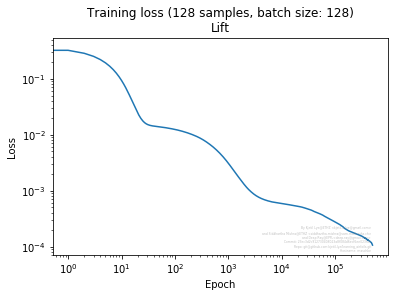

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


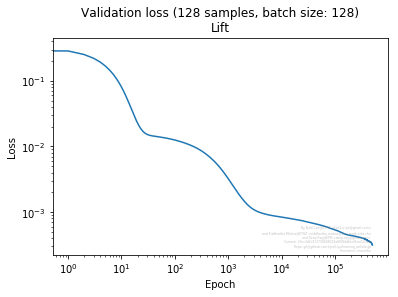

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


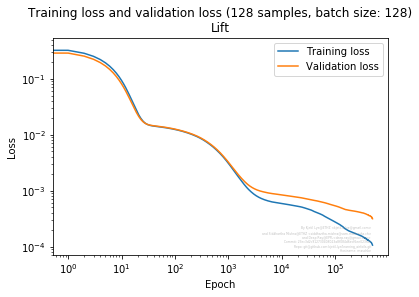

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


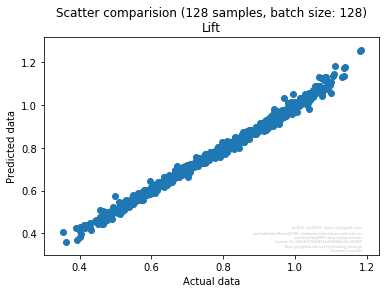

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_29 (Dense)             (None, 10)                70        
_________________________________________________________________
activation_25 (Activation)   (None, 10)                0         
_________________________________________________________________
dense_30 (Dense)             (None, 12)                132       
_________________________________________________________________
activation_26 (Activation)   (None, 12)                0         
_________________________________________________________________
dense_31 (Dense)             (None, 10)                130       
_________________________________________________________________
activation_27 (Activation)   (None, 10)                0         
_________________________________________________________________
dense_32 (Dense)             (None, 12)                132       
__________

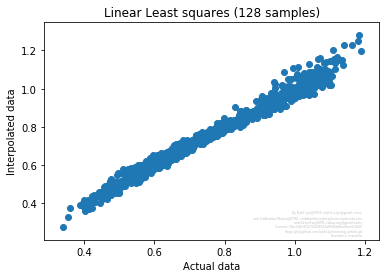

variance single level = 0.031350
variance diff ml = 0.000271 
speedup = 115.651885
(1001,)
variance_diff_interpolate = 0.000684
mean_qmc = 0.770562
mean_ml = 0.771039
mean_few_qmc = 0.496094
(8000,)
mean_mlmlmc = 0.771313
var_qmc = 0.031350
var_ml = 0.030882
var_few_qmc = 0.083328
(1001, 6)
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


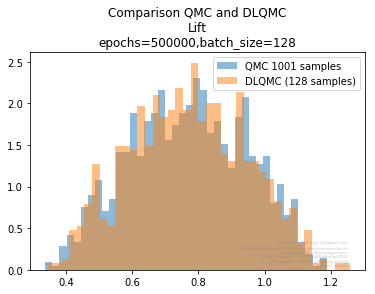

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


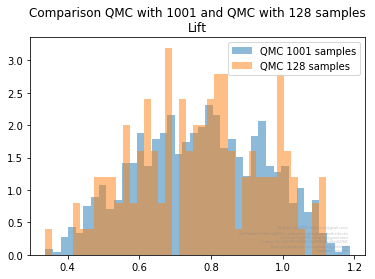

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


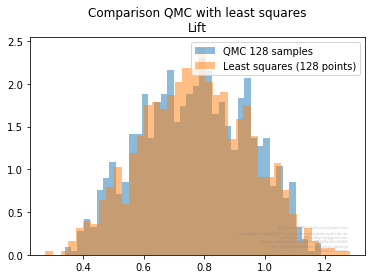

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


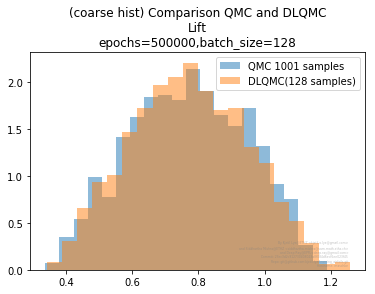

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


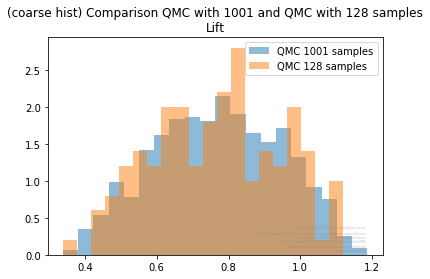

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


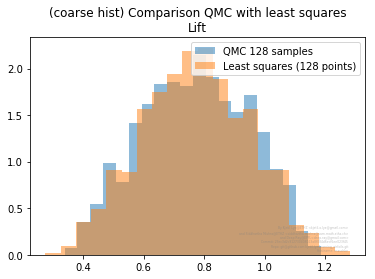

0.06223177613353695


/u/klye/.local/lib/python3.6/site-packages/ipykernel_launcher.py:241: RuntimeWarning: invalid value encountered in double_scalars


Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


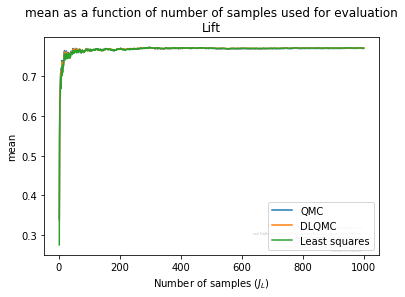

/u/klye/.local/lib/python3.6/site-packages/ipykernel_launcher.py:243: RuntimeWarning: invalid value encountered in double_scalars


Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


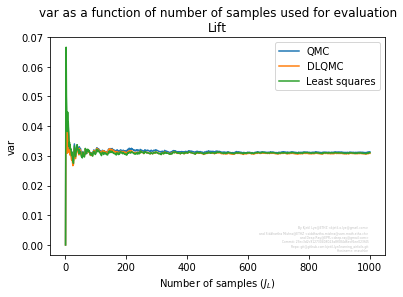

\multicolumn{2}{c|}{\textbf{QMC}} &&\multicolumn{2}{c|}{\textbf{DLQMC}} &&\multicolumn{2}{c|}{\textbf{Least squares}} &&\multicolumn{2}{c|}{\textbf{DLbQMC}} &&\multicolumn{2}{c|}{\textbf{QMC_128}} \\ 
&mean & var && mean & var && mean & var && mean & var && mean & var \\  Lift & 0.77077 & 0.03134 && 0.77125 & 0.03087 && 0.77152 & 0.03106 && 0.77122 & 0.04483 && 0.76806 & 0.03169 \\ 
 

#############################################
#airfoil_Lift_ts_128_bs_128_comparison_stats#
#############################################
-----------------  --------------------  ------------------  --------------------  ------------------  --------------------  ------------------  -------------------  ------------------  --------------------
QMC                QMC                   DLQMC               DLQMC                 Least squares       Least squares         DLbQMC              DLbQMC               QMC_128             QMC_128
mean               var                   mean                var        

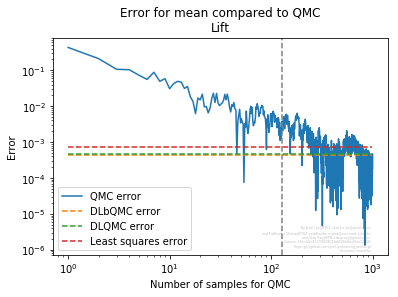

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


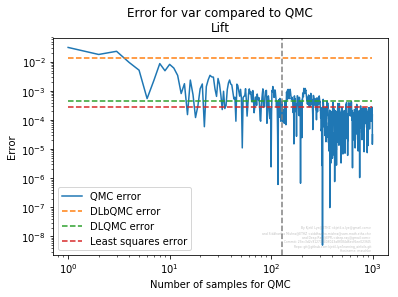



########################################
#airfoil_Lift_ts_128_bs_128_wasserstein#
########################################
------------------  ------------------  -------
DLQMC               Least squares       QMC 128
1.0403662388854158  0.7985241288204734  1.0
------------------  ------------------  -------
########################################


\toprule
&DLQMC & Least squares & QMC 128\\
\midrule
Lift & 1.0403662388854158 & 0.7985241288204734 & 1.0
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


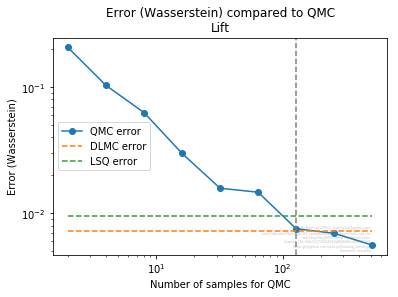

Training took 1226.2850918769836 seconds
Training took 1249.3227670192719 seconds
Training took 1286.1812019348145 seconds
Training took 1316.410078048706 seconds
Training took 1353.6502232551575 seconds
Best network index: 0
Total learning time took: 6434 s


###########################################
#airfoil_Drag_ts_128_bs_128_airfoilnetwork#
###########################################
-----  ----  ----------
Layer  Size  Parameters
0      10    70
1      10    110
2      12    132
3      12    156
4      10    130
5      10    110
6      12    132
7      12    156
8      10    130
9      10    110
10     10    110
11     10    110
12     1     11
Sum          1467
-----  ----  ----------
###########################################


Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


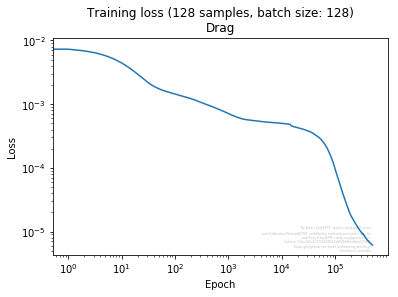

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


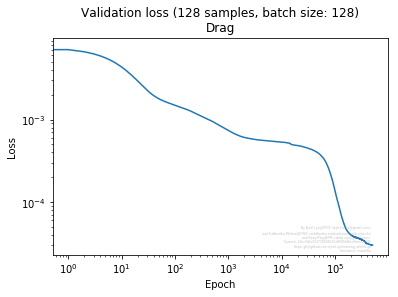

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


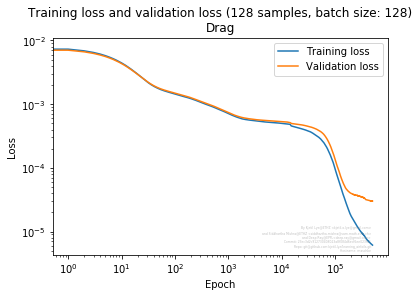

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


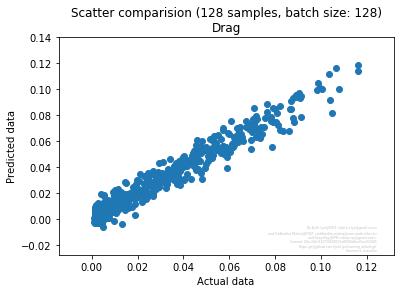

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_36 (Dense)             (None, 10)                70        
_________________________________________________________________
activation_31 (Activation)   (None, 10)                0         
_________________________________________________________________
dense_37 (Dense)             (None, 12)                132       
_________________________________________________________________
activation_32 (Activation)   (None, 12)                0         
_________________________________________________________________
dense_38 (Dense)             (None, 10)                130       
_________________________________________________________________
activation_33 (Activation)   (None, 10)                0         
_________________________________________________________________
dense_39 (Dense)             (None, 12)                132       
__________

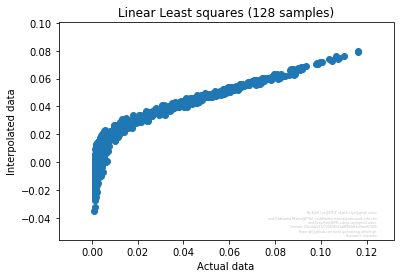

variance single level = 0.000701
variance diff ml = 0.000026 
speedup = 27.125219
(1001,)
variance_diff_interpolate = 0.000131
mean_qmc = 0.023544
mean_ml = 0.023582
mean_few_qmc = 0.496094
(8000,)
mean_mlmlmc = 0.023477
var_qmc = 0.000701
var_ml = 0.000694
var_few_qmc = 0.083328
(1001, 6)
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


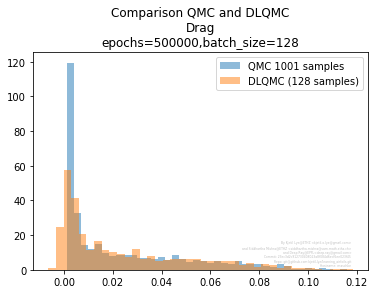

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


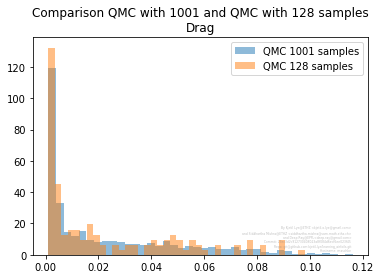

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


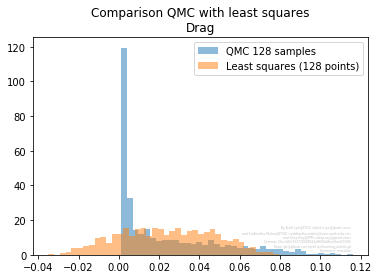

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


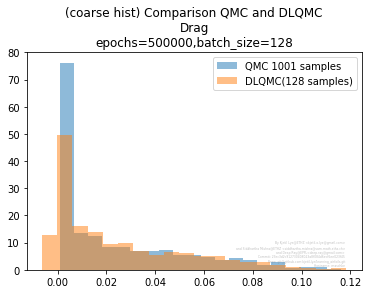

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


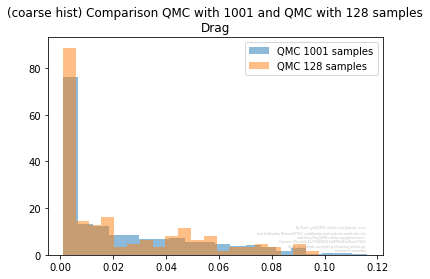

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


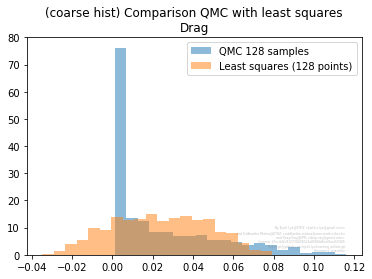

0.0013949390847140081


/u/klye/.local/lib/python3.6/site-packages/ipykernel_launcher.py:241: RuntimeWarning: invalid value encountered in double_scalars


Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


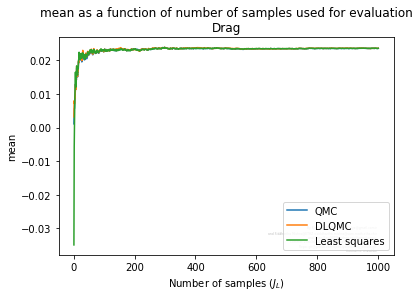

/u/klye/.local/lib/python3.6/site-packages/ipykernel_launcher.py:243: RuntimeWarning: invalid value encountered in double_scalars


Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


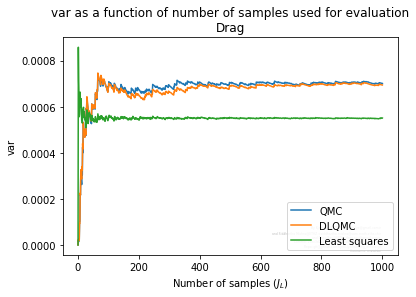

\multicolumn{2}{c|}{\textbf{QMC}} &&\multicolumn{2}{c|}{\textbf{DLQMC}} &&\multicolumn{2}{c|}{\textbf{Least squares}} &&\multicolumn{2}{c|}{\textbf{DLbQMC}} &&\multicolumn{2}{c|}{\textbf{QMC_128}} \\ 
&mean & var && mean & var && mean & var && mean & var && mean & var \\  Drag & 0.02357 & 0.00070 && 0.02361 & 0.00069 && 0.02358 & 0.00055 && 0.02358 & 0.00118 && 0.02317 & 0.00068 \\ 
 

#############################################
#airfoil_Drag_ts_128_bs_128_comparison_stats#
#############################################
--------------------  ---------------------  --------------------  ---------------------  --------------------  ---------------------  --------------------  ---------------------  --------------------  ---------------------
QMC                   QMC                    DLQMC                 DLQMC                  Least squares         Least squares          DLbQMC                DLbQMC                 QMC_128               QMC_128
mean                  var              

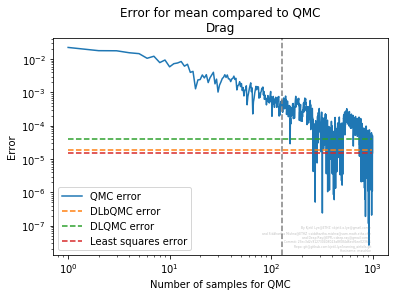

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


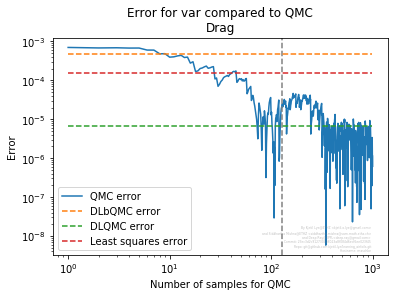



########################################
#airfoil_Drag_ts_128_bs_128_wasserstein#
########################################
------------------  -------------------  -------
DLQMC               Least squares        QMC 128
0.8360929979839544  0.12130703102237402  1.0
------------------  -------------------  -------
########################################


\toprule
&DLQMC & Least squares & QMC 128\\
\midrule
Drag & 0.8360929979839544 & 0.12130703102237402 & 1.0
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


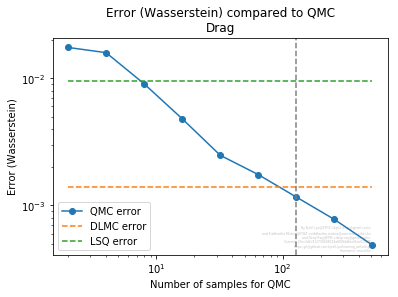



###################################
#airfoil_all_ts_128_bs_128_speedup#
###################################
----  -------  -------  -----------------  ------------------  -----------------  --------------------  -----------------  -------------------
      QMC_128  QMC_128  DLQMC              DLQMC               DLbQMC             DLbQMC                Least squares      Least squares
      mean     var      mean               var                 mean               var                   mean               var
Lift  1.0      1.0      5.629173044602486  0.7489567333982888  6.124700071250305  0.026101764556864505  3.630564975117658  1.2690041702549897
Drag  1.0      1.0      9.602956558756246  3.2807022391225753  21.34158506431387  0.04432840381591638   25.00904506475582  0.14287602489259812
----  -------  -------  -----------------  ------------------  -----------------  --------------------  -----------------  -------------------
###################################




###############

Training took 1516.172165632248 seconds
Training took 1599.0005266666412 seconds
Training took 1666.3996410369873 seconds
Training took 1706.7289202213287 seconds
Training took 1785.8833117485046 seconds
Best network index: 4
Total learning time took: 8277 s


#################################################
#airfoil_adams_Lift_ts_128_bs_128_airfoilnetwork#
#################################################
-----  ----  ----------
Layer  Size  Parameters
0      10    70
1      10    110
2      12    132
3      12    156
4      10    130
5      10    110
6      12    132
7      12    156
8      10    130
9      10    110
10     10    110
11     10    110
12     1     11
Sum          1467
-----  ----  ----------
#################################################


Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


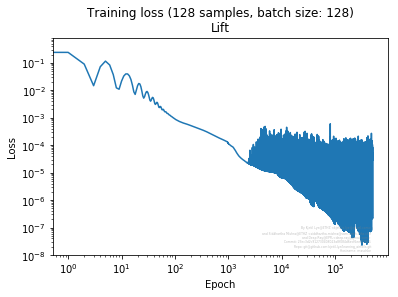

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


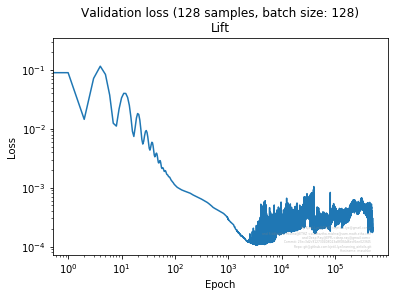

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


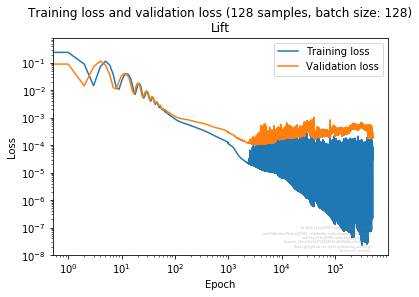

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


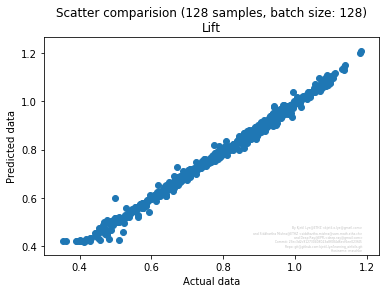

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_99 (Dense)             (None, 10)                70        
_________________________________________________________________
activation_85 (Activation)   (None, 10)                0         
_________________________________________________________________
dense_100 (Dense)            (None, 12)                132       
_________________________________________________________________
activation_86 (Activation)   (None, 12)                0         
_________________________________________________________________
dense_101 (Dense)            (None, 10)                130       
_________________________________________________________________
activation_87 (Activation)   (None, 10)                0         
_________________________________________________________________
dense_102 (Dense)            (None, 12)                132       
__________

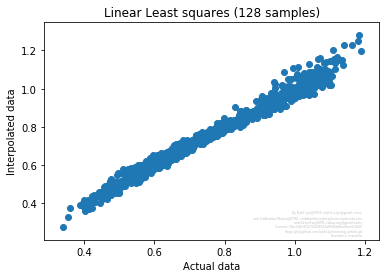

variance single level = 0.031350
variance diff ml = 0.000189 
speedup = 165.900826
(1001,)
variance_diff_interpolate = 0.000684
mean_qmc = 0.770562
mean_ml = 0.765308
mean_few_qmc = 0.496094
(8000,)
mean_mlmlmc = 0.761267
var_qmc = 0.031350
var_ml = 0.030674
var_few_qmc = 0.083328
(1001, 6)
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


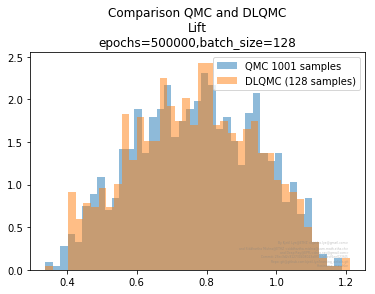

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


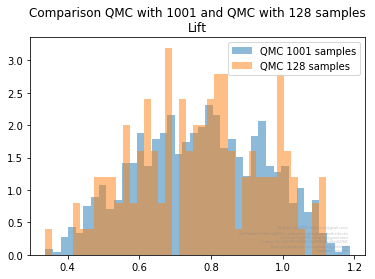

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


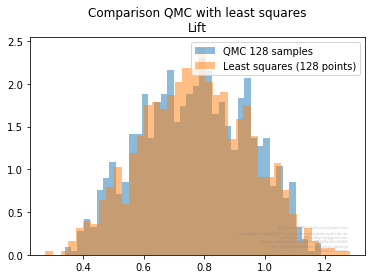

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


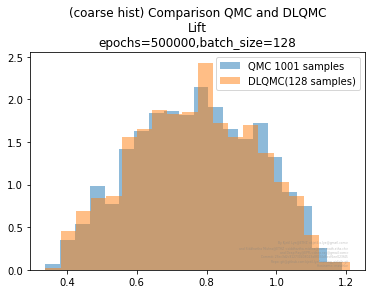

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


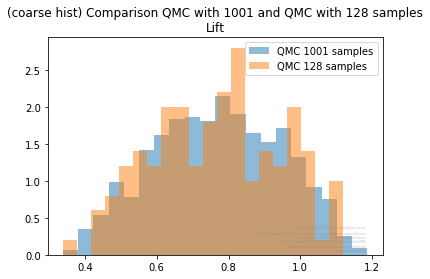

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


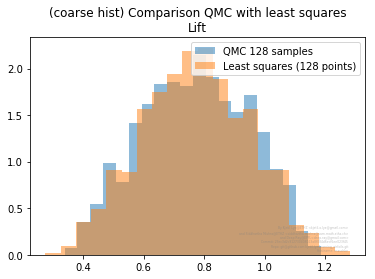

0.06205152205106835


/u/klye/.local/lib/python3.6/site-packages/ipykernel_launcher.py:241: RuntimeWarning: invalid value encountered in double_scalars


Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


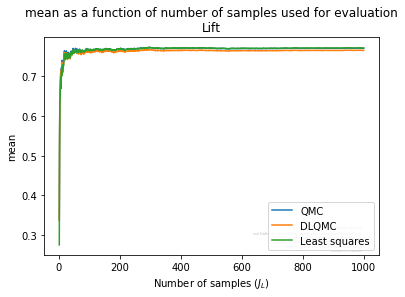

/u/klye/.local/lib/python3.6/site-packages/ipykernel_launcher.py:243: RuntimeWarning: invalid value encountered in double_scalars


Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


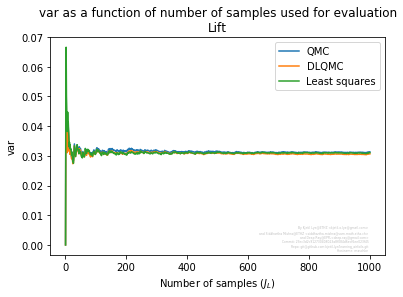

\multicolumn{2}{c|}{\textbf{QMC}} &&\multicolumn{2}{c|}{\textbf{DLQMC}} &&\multicolumn{2}{c|}{\textbf{Least squares}} &&\multicolumn{2}{c|}{\textbf{DLbQMC}} &&\multicolumn{2}{c|}{\textbf{QMC_128}} \\ 
&mean & var && mean & var && mean & var && mean & var && mean & var \\  Lift & 0.77077 & 0.03134 && 0.76552 & 0.03066 && 0.77152 & 0.03106 && 0.18612 & 1.54607 && 0.76806 & 0.03169 \\ 
 

###################################################
#airfoil_adams_Lift_ts_128_bs_128_comparison_stats#
###################################################
-----------------  --------------------  -----------  --------------------  ------------------  --------------------  ------------------  ------------------  ------------------  --------------------
QMC                QMC                   DLQMC        DLQMC                 Least squares       Least squares         DLbQMC              DLbQMC              QMC_128             QMC_128
mean               var                   mean         var             

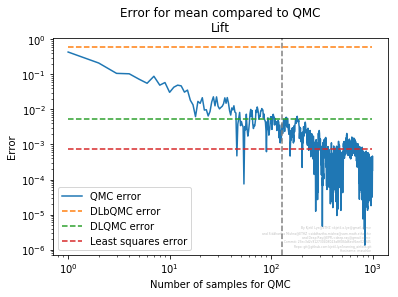

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


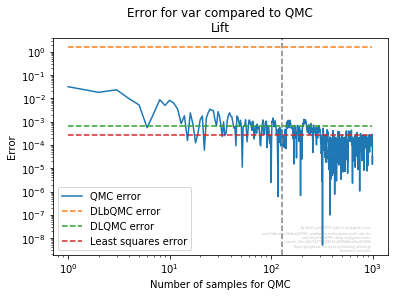



##############################################
#airfoil_adams_Lift_ts_128_bs_128_wasserstein#
##############################################
------------------  ------------------  -------
DLQMC               Least squares       QMC 128
1.4653391340071884  0.7985241288204734  1.0
------------------  ------------------  -------
##############################################


\toprule
&DLQMC & Least squares & QMC 128\\
\midrule
Lift & 1.4653391340071884 & 0.7985241288204734 & 1.0
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


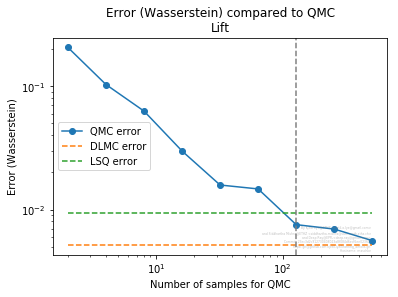

Training took 1846.6046442985535 seconds
Training took 1945.791339635849 seconds
Training took 1977.0260379314423 seconds
Training took 2026.8373003005981 seconds
Training took 2085.6392736434937 seconds
Best network index: 0
Total learning time took: 9886 s


#################################################
#airfoil_adams_Drag_ts_128_bs_128_airfoilnetwork#
#################################################
-----  ----  ----------
Layer  Size  Parameters
0      10    70
1      10    110
2      12    132
3      12    156
4      10    130
5      10    110
6      12    132
7      12    156
8      10    130
9      10    110
10     10    110
11     10    110
12     1     11
Sum          1467
-----  ----  ----------
#################################################


Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


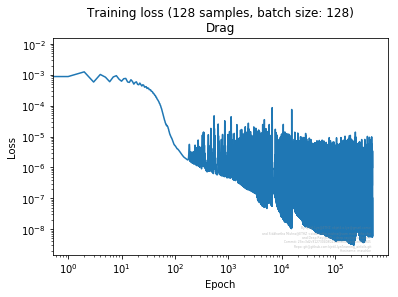

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


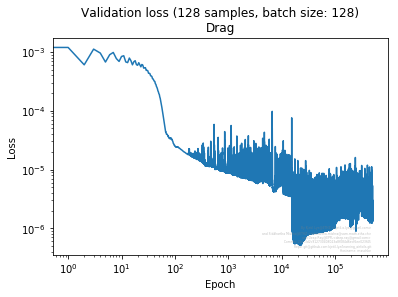

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


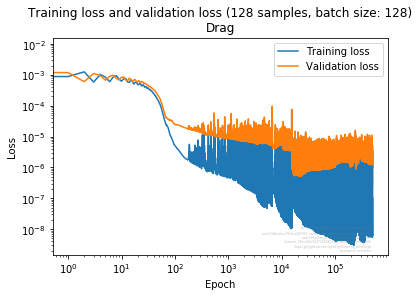

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


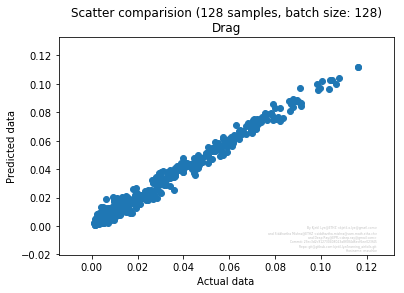

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_106 (Dense)            (None, 10)                70        
_________________________________________________________________
activation_91 (Activation)   (None, 10)                0         
_________________________________________________________________
dense_107 (Dense)            (None, 12)                132       
_________________________________________________________________
activation_92 (Activation)   (None, 12)                0         
_________________________________________________________________
dense_108 (Dense)            (None, 10)                130       
_________________________________________________________________
activation_93 (Activation)   (None, 10)                0         
_________________________________________________________________
dense_109 (Dense)            (None, 12)                132       
__________

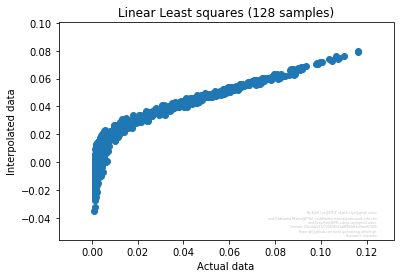

variance single level = 0.000701
variance diff ml = 0.000008 
speedup = 91.357202
(1001,)
variance_diff_interpolate = 0.000131
mean_qmc = 0.023544
mean_ml = 0.023644
mean_few_qmc = 0.496094
(8000,)
mean_mlmlmc = 0.023730
var_qmc = 0.000701
var_ml = 0.000686
var_few_qmc = 0.083328
(1001, 6)
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


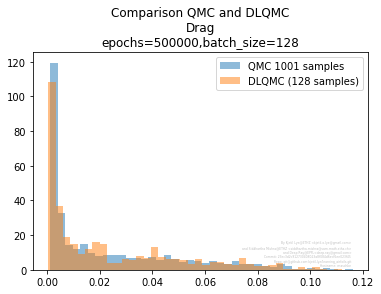

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


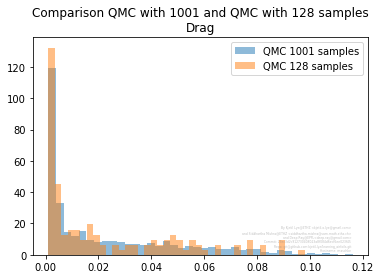

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


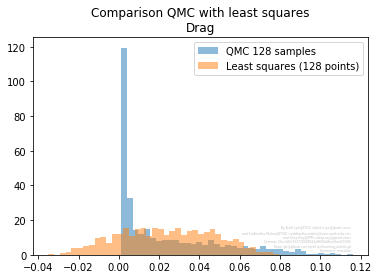

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


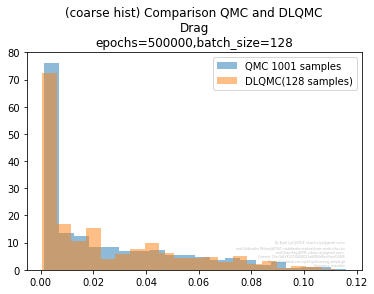

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


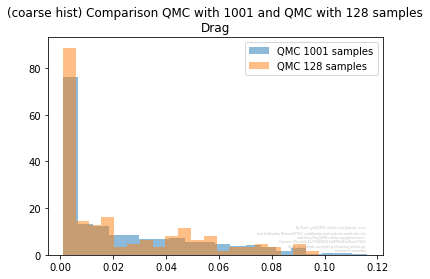

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


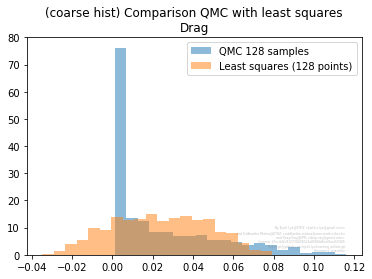

0.0013867037095935278


/u/klye/.local/lib/python3.6/site-packages/ipykernel_launcher.py:241: RuntimeWarning: invalid value encountered in double_scalars


Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


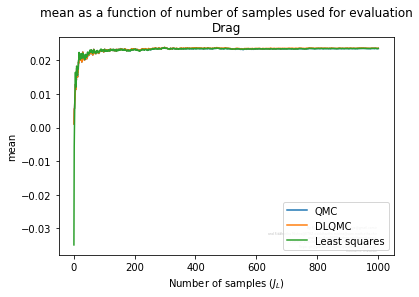

/u/klye/.local/lib/python3.6/site-packages/ipykernel_launcher.py:243: RuntimeWarning: invalid value encountered in double_scalars


Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


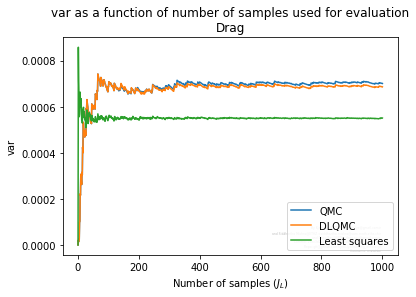

\multicolumn{2}{c|}{\textbf{QMC}} &&\multicolumn{2}{c|}{\textbf{DLQMC}} &&\multicolumn{2}{c|}{\textbf{Least squares}} &&\multicolumn{2}{c|}{\textbf{DLbQMC}} &&\multicolumn{2}{c|}{\textbf{QMC_128}} \\ 
&mean & var && mean & var && mean & var && mean & var && mean & var \\  Drag & 0.02357 & 0.00070 && 0.02367 & 0.00069 && 0.02358 & 0.00055 && 0.02337 & 0.00072 && 0.02317 & 0.00068 \\ 
 

###################################################
#airfoil_adams_Drag_ts_128_bs_128_comparison_stats#
###################################################
--------------------  ---------------------  --------------------  ---------------------  --------------------  ---------------------  -------------------  ---------------------  --------------------  ---------------------
QMC                   QMC                    DLQMC                 DLQMC                  Least squares         Least squares          DLbQMC               DLbQMC                 QMC_128               QMC_128
mean                  v

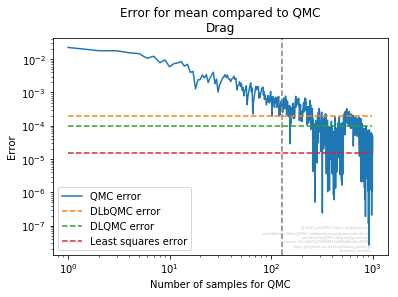

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


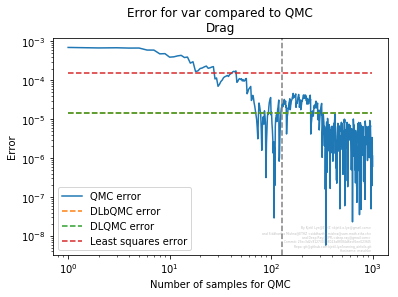



##############################################
#airfoil_adams_Drag_ts_128_bs_128_wasserstein#
##############################################
------------------  -------------------  -------
DLQMC               Least squares        QMC 128
1.3337714047583085  0.12130703102237402  1.0
------------------  -------------------  -------
##############################################


\toprule
&DLQMC & Least squares & QMC 128\\
\midrule
Drag & 1.3337714047583085 & 0.12130703102237402 & 1.0
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


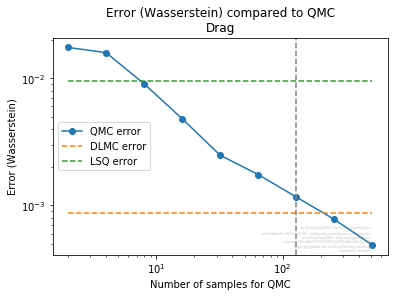



#########################################
#airfoil_all_adams_ts_128_bs_128_speedup#
#########################################
----  -------  -------  ------------------  ------------------  --------------------  ---------------------  -----------------  -------------------
      QMC_128  QMC_128  DLQMC               DLQMC               DLbQMC                DLbQMC                 Least squares      Least squares
      mean     var      mean                var                 mean                  var                    mean               var
Lift  1.0      1.0      0.515328039844726   0.5218538913223714  0.004633952585832209  0.0002324386081216322  3.630564975117658  1.2690041702549897
Drag  1.0      1.0      3.9314520315637465  1.4625294987630333  2.011230308555241     1.4751170524658337     25.00904506475582  0.14287602489259812
----  -------  -------  ------------------  ------------------  --------------------  ---------------------  -----------------  -------------------
#######

In [3]:
force_names=['Lift', 'Drag']
batch_sizes=[train_size]

for batch_size in batch_sizes:
    speedup_table = TableBuilder()
    comparison_table = TableBuilder()
    wasserstein_table_builder = TableBuilder()
    bilevel_speedup_table= TableBuilder()
    prediction_error_table = TableBuilder()
    for (n, f) in enumerate(force_names):
        showAndSave.prefix='airfoil_%s_ts_%d_bs_%d' %(f,batch_size, train_size)
        network= get_network(qmc_points, forces[:,n+1], train_size=train_size, validation_size=validation_size,
                        batch_size=batch_size, title=f, optimizer=keras.optimizers.SGD,
                            speedup_table=speedup_table,
                            comparison_table=comparison_table,
                            wasserstein_table_builder=wasserstein_table_builder,
                            bilevel_speedup_table=bilevel_speedup_table,
                            prediction_error_table=prediction_error_table)
    showAndSave.prefix='airfoil_all_ts_%d_bs_%d' %(batch_size, train_size)
    speedup_table.print_table('speedup')
    comparison_table.print_table('comparison')
    wasserstein_table_builder.print_table("wasserstein")
    bilevel_speedup_table.print_table("bilevel_speedup")
    prediction_error_table.print_table("prediction_error_table")
display(HTML("<h1>Adams</h1>"))
seed_random_number(random_seed)
for batch_size in batch_sizes:
    speedup_table = TableBuilder()
    comparison_table = TableBuilder()
    wasserstein_table_builder = TableBuilder()
    bilevel_speedup_table= TableBuilder()
    prediction_error_table = TableBuilder()
    for (n, f) in enumerate(force_names):
        showAndSave.prefix='airfoil_adams_%s_ts_%d_bs_%d' %(f,batch_size, train_size)
        network= get_network(qmc_points, forces[:,n+1], train_size=train_size, validation_size=validation_size,
                        batch_size=batch_size, title=f, optimizer=keras.optimizers.Adam,
                            speedup_table=speedup_table,
                            comparison_table=comparison_table,
                            wasserstein_table_builder=wasserstein_table_builder,
                            bilevel_speedup_table=bilevel_speedup_table,
                            prediction_error_table=prediction_error_table)
        
    showAndSave.prefix='airfoil_all_adams_ts_%d_bs_%d' %(batch_size, train_size)
    speedup_table.print_table('speedup')
    comparison_table.print_table('comparison')
    wasserstein_table_builder.print_table("wasserstein")
    bilevel_speedup_table.print_table("bilevel_speedup")
    prediction_error_table.print_table("prediction_error_table")